In [ ]:
import numpy as np
import glob
import os
from models.JetPointNet import PointNetSegmentation


def load_data_from_npz(npz_file):
    data = np.load(npz_file)
    feats = data['feats']  # Shape: (num_samples, 859, 6)
    frac_labels = data['frac_labels']  # Shape: (num_samples, 859)
    tot_labels = data['tot_labels']  # Shape: (num_samples, 859)
    tot_truth_e = data['tot_truth_e']  # Shape: (num_samples, 859) (This is the true total energy deposited by particles into this cell)
    return feats, frac_labels, tot_labels, tot_truth_e

# Setup
os.environ['CUDA_VISIBLE_DEVICES'] = ""  # Disable GPU
model_path = "saved_model/PointNetModel.keras"

TEST_DIR = '/data/mjovanovic/jets/processed_files/2000_events_w_fixed_hits/SavedNpz/test'

model = PointNetSegmentation(num_points=278, num_classes=1)
model.load_weights(model_path)

npz_files = glob.glob(os.path.join(TEST_DIR, '*.npz'))



In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data collections
num_points_list = []
accuracies_list = []
random_accuracies_list = []  # For storing random guess accuracies

# Lists to store total true energy and focused particle p_t for later binning
total_true_energy_samples = []
focused_particle_pts = []

# Minimum number of samples per bin to be included in the output
min_samples_per_bin = 10

# Process each file
for npz_file_idx, npz_file in enumerate(npz_files):
    feats, frac_labels, tot_labels, tot_truth_e = load_data_from_npz(npz_file)
    segmentation_logits = model.predict(feats)
    segmentation_logits = np.squeeze(segmentation_logits, axis=-1)

    for sample_idx in range(len(feats)):
        sample_features = feats[sample_idx]
        energies = tot_labels[sample_idx]
        tot_true_energy = tot_truth_e[sample_idx]

        energy_point_indices = sample_features[:, 6] == 1

        predicted_classes = np.where(segmentation_logits[sample_idx] > 0, 1, 0)
        true_classes = np.where(frac_labels[sample_idx] > 0.5, 1, 0)

        energies_filtered = tot_truth_e[sample_idx][energy_point_indices]
        predicted_classes_filtered = predicted_classes[energy_point_indices]
        true_classes_filtered = true_classes[energy_point_indices]

        # Random guess predictions
        random_predictions = np.random.randint(0, 2, size=true_classes_filtered.shape)

        correct_predictions = predicted_classes_filtered == true_classes_filtered
        correct_random_predictions = random_predictions == true_classes_filtered

        correct_energy = np.sum(np.abs(energies_filtered[correct_predictions]))
        correct_random_energy = np.sum(np.abs(energies_filtered[correct_random_predictions]))

        total_energy = np.sum(np.abs(energies_filtered))

        energy_weighted_accuracy = correct_energy / (total_energy + 1e-5)
        random_energy_weighted_accuracy = correct_random_energy / (total_energy + 1e-5)

        # Collect total true energy and particle p_t for this sample
        total_true_energy_sample = np.sum(energies_filtered)
        focused_particle_pt = sample_features[0, 4]

        total_true_energy_samples.append(total_true_energy_sample)
        focused_particle_pts.append(focused_particle_pt)
        accuracies_list.append(energy_weighted_accuracy)
        random_accuracies_list.append(random_energy_weighted_accuracy)

        print("Sample Index: ", sample_idx)
        print("Total number of cells in sample: ", np.sum(energy_point_indices))
        print("Predicted Count: ", np.sum(predicted_classes_filtered))
        print("True Count: ", np.sum(true_classes_filtered))
        print("Energy Weighted Accuracy: ", energy_weighted_accuracy)
        print("Random Guess Energy Weighted Accuracy: ", random_energy_weighted_accuracy)
        print()

# Creating bins based on the full range of collected data
energy_bins = np.linspace(min(total_true_energy_samples), max(total_true_energy_samples), num=21)
pt_bins = np.linspace(min(focused_particle_pts), max(focused_particle_pts), num=21)

# Dictionaries to accumulate data for the new bins
energy_acc = {bin_edge: [] for bin_edge in energy_bins}
pt_acc = {bin_edge: [] for bin_edge in pt_bins}

random_energy_acc = {bin_edge: [] for bin_edge in energy_bins}  # For random guess accuracies
random_pt_acc = {bin_edge: [] for bin_edge in pt_bins}

# Accumulate data into bins
for i in range(len(accuracies_list)):
    energy_bin_index = np.digitize(total_true_energy_samples[i], energy_bins) - 1
    pt_bin_index = np.digitize(focused_particle_pts[i], pt_bins) - 1

    if 0 <= energy_bin_index < len(energy_bins):
        energy_acc[energy_bins[energy_bin_index]].append(accuracies_list[i])
        random_energy_acc[energy_bins[energy_bin_index]].append(random_accuracies_list[i])
    if 0 <= pt_bin_index < len(pt_bins):
        pt_acc[pt_bins[pt_bin_index]].append(accuracies_list[i])
        random_pt_acc[pt_bins[pt_bin_index]].append(random_accuracies_list[i])


# Calculate and print the mean accuracies for each bin if the bin has at least min_samples_per_bin samples
# Calculate and print the mean accuracies for each bin if the bin has at least min_samples_per_bin samples
print("Mean Weighted Accuracies by Total True Energy Bin:")
for bin_edge in energy_bins:
    if len(energy_acc[bin_edge]) >= min_samples_per_bin:
        print(f"Energy {bin_edge:.2f}:")
        print(f"  Network Accuracy: {np.mean(energy_acc[bin_edge]):.3f}")
        print(f"  Random Guess Accuracy: {np.mean(random_energy_acc[bin_edge]):.3f}")

print("\nMean Weighted Accuracies by Focused Particle p_t Bin:")
for bin_edge in pt_bins:
    if len(pt_acc[bin_edge]) >= min_samples_per_bin:
        print(f"Particle p_t {bin_edge:.2f}:")
        print(f"  Network Accuracy: {np.mean(pt_acc[bin_edge]):.3f}")
        print(f"  Random Guess Accuracy: {np.mean(random_pt_acc[bin_edge]):.3f}")

# Calculate overall mean weighted accuracy
mean_weighted_accuracy = np.mean(accuracies_list)
mean_random_weighted_accuracy = np.mean(random_accuracies_list)
print("\nOverall Mean Weighted Accuracy: ", f"{mean_weighted_accuracy:.3f}")
print("Overall Mean Random Guess Weighted Accuracy: ", f"{mean_random_weighted_accuracy:.3f}")


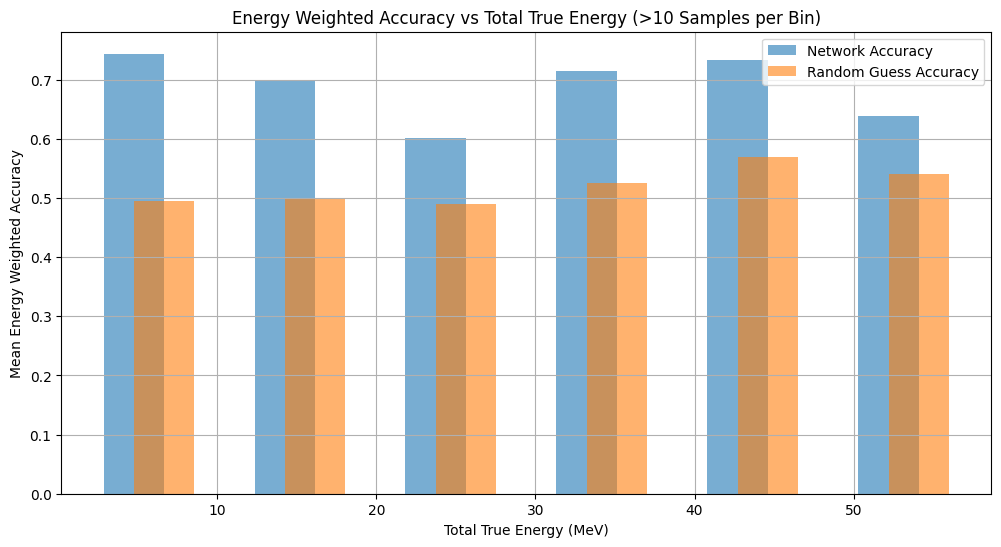

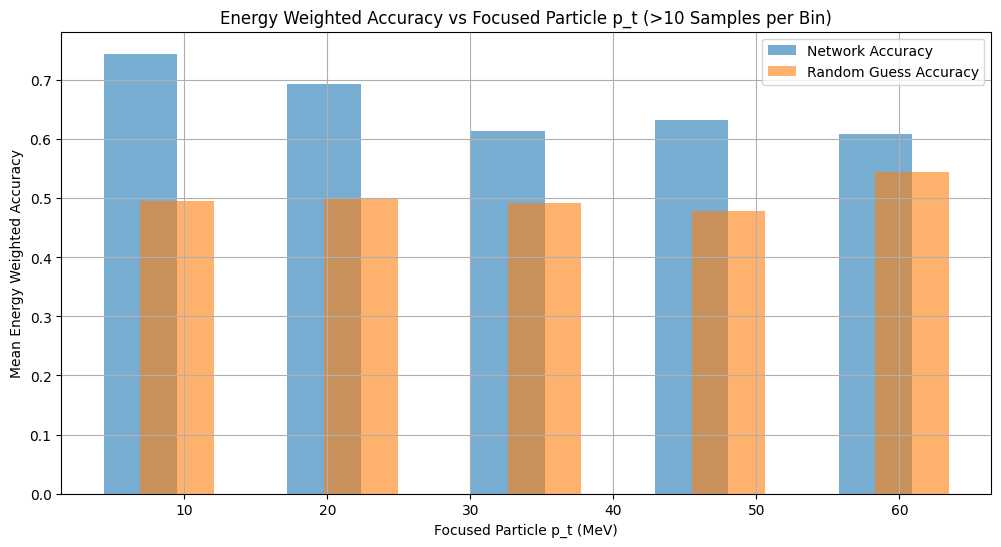

In [36]:
# take a look carefully, and check the changes
# now I want you to make it so for this bar graph, the bar locations and widths correspond to the bin edges ,so one can look at the plot and see where the bins are located and what energies they span. If there is a bin without any items (or less than the minimum) just set it to zero for both random and network predictions.
import matplotlib.pyplot as plt


# Prepare the data for plotting
energy_centers = [(energy_bins[i] + energy_bins[i+1]) / 2 for i in range(len(energy_bins)-1)]
network_acc_energy = [np.mean(energy_acc[bin]) if len(energy_acc[bin]) >= min_samples_per_bin else None for bin in energy_bins[:-1]]
random_acc_energy = [np.mean(random_energy_acc[bin]) if len(random_energy_acc[bin]) >= min_samples_per_bin else None for bin in energy_bins[:-1]]
energy_bin_width = energy_bins[1] - energy_bins[0]  # Assuming uniform bin sizes for simplicity

pt_centers = [(pt_bins[i] + pt_bins[i+1]) / 2 for i in range(len(pt_bins)-1)]
network_acc_pt = [np.mean(pt_acc[bin]) if len(pt_acc[bin]) >= min_samples_per_bin else None for bin in pt_bins[:-1]]
random_acc_pt = [np.mean(random_pt_acc[bin]) if len(random_pt_acc[bin]) >= min_samples_per_bin else None for bin in pt_bins[:-1]]
pt_bin_width = pt_bins[1] - pt_bins[0]  # Assuming uniform bin sizes for simplicity
import matplotlib.pyplot as plt

# Prepare the data for plotting, ensuring no None values are included
energy_centers_filtered, network_acc_energy_filtered, random_acc_energy_filtered = zip(
    *[(center, net_acc, rand_acc) for center, net_acc, rand_acc in zip(
        energy_centers, network_acc_energy, random_acc_energy) if net_acc is not None and rand_acc is not None])

pt_centers_filtered, network_acc_pt_filtered, random_acc_pt_filtered = zip(
    *[(center, net_acc, rand_acc) for center, net_acc, rand_acc in zip(
        pt_centers, network_acc_pt, random_acc_pt) if net_acc is not None and rand_acc is not None])

# Plotting Energy vs Accuracy
plt.figure(figsize=(12, 6))
plt.bar(energy_centers_filtered, network_acc_energy_filtered, width=energy_bin_width*0.4, align='center', alpha=0.6, label='Network Accuracy')
plt.bar(energy_centers_filtered, random_acc_energy_filtered, width=energy_bin_width*0.4, align='edge', alpha=0.6, label='Random Guess Accuracy')
plt.xlabel('Total True Energy (MeV)')
plt.ylabel('Mean Energy Weighted Accuracy')
plt.title('Energy Weighted Accuracy vs Total True Energy (>10 Samples per Bin)')
plt.legend()
plt.grid(True)
plt.show()

# Plotting Pt vs Accuracy
plt.figure(figsize=(12, 6))
plt.bar(pt_centers_filtered, network_acc_pt_filtered, width=pt_bin_width*0.4, align='center', alpha=0.6, label='Network Accuracy')
plt.bar(pt_centers_filtered, random_acc_pt_filtered, width=pt_bin_width*0.4, align='edge', alpha=0.6, label='Random Guess Accuracy')
plt.xlabel('Focused Particle p_t (MeV)')
plt.ylabel('Mean Energy Weighted Accuracy')
plt.title('Energy Weighted Accuracy vs Focused Particle p_t (>10 Samples per Bin)')
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
# HISTOGRAM

In [ ]:
# PLOT SOME 3D EVENT DISPLAYS